# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "/home/sangram/Downloads/Photos/training"
    testing_dir = "/home/sangram/Downloads/Photos/testing"
    train_batch_size = 16
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [ ]:
# Training DataSet Generator

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
# Siamese Bagging DataSet Generator

In [5]:
class BaggingCoupledSiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[index]
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)), int(img0_tuple[1]), int(img1_tuple[1]) 
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [7]:
siamese_dataset = BaggingCoupledSiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


## Neural Net Definition
We will use a standard convolutional neural network

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 20))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=False,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [11]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [12]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.34656667709

Epoch number 0
 Current loss 4.83911800385

Epoch number 0
 Current loss 2.20910906792

Epoch number 1
 Current loss 7.14749193192

Epoch number 1
 Current loss 3.3227391243

Epoch number 1
 Current loss 1.26823997498

Epoch number 2
 Current loss 1.83787059784

Epoch number 2
 Current loss 0.832332611084

Epoch number 2
 Current loss 1.27669143677

Epoch number 3
 Current loss 1.57427072525

Epoch number 3
 Current loss 0.947252392769

Epoch number 3
 Current loss 0.991602659225

Epoch number 4
 Current loss 2.30831694603

Epoch number 4
 Current loss 1.15325498581

Epoch number 4
 Current loss 1.90146803856

Epoch number 5
 Current loss 2.31897497177

Epoch number 5
 Current loss 0.786789178848

Epoch number 5
 Current loss 0.722946941853

Epoch number 6
 Current loss 1.47935605049

Epoch number 6
 Current loss 0.755324602127

Epoch number 6
 Current loss 1.27183973789

Epoch number 7
 Current loss 1.30577254295

Epoch number 7
 Current los

Epoch number 60
 Current loss 2.39312505722

Epoch number 61
 Current loss 1.02314162254

Epoch number 61
 Current loss 1.36660134792

Epoch number 61
 Current loss 1.13867044449

Epoch number 62
 Current loss 0.86458837986

Epoch number 62
 Current loss 1.11079609394

Epoch number 62
 Current loss 2.01548981667

Epoch number 63
 Current loss 0.747478246689

Epoch number 63
 Current loss 1.36882078648

Epoch number 63
 Current loss 0.879718542099

Epoch number 64
 Current loss 1.36527192593

Epoch number 64
 Current loss 1.17874765396

Epoch number 64
 Current loss 1.39800155163

Epoch number 65
 Current loss 0.942800164223

Epoch number 65
 Current loss 0.66765588522

Epoch number 65
 Current loss 0.760216832161

Epoch number 66
 Current loss 0.816941916943

Epoch number 66
 Current loss 0.891481399536

Epoch number 66
 Current loss 0.931514263153

Epoch number 67
 Current loss 1.09177446365

Epoch number 67
 Current loss 1.06874871254

Epoch number 67
 Current loss 0.508801698685

Ep

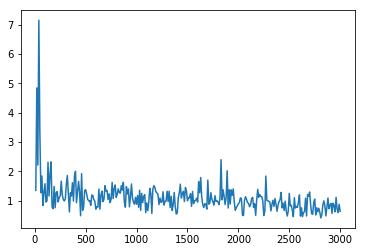

In [13]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1, label,_,_= data
#        print _1,'--',_2
        img0, img1, label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1, output2 = net(img0,img1)
        net.zero_grad()
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print "Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0])
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

In [14]:
net.save_state_dict('/home/sangram/Downloads/mytraining.pt')

AttributeError: 'SiameseNetwork' object has no attribute 'save_state_dict'

In [ ]:
net.load_state_dict(torch.load('/home/sangram/Downloads/mytraining.pt'))

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [33]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset_bagging_test = BaggingCoupledSiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset_bagging_test,num_workers=6,batch_size=1,shuffle=True)
training_dataloader_bag = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)

dictionary_head = {0:'Benign', 1:'InSitu', 2:'Invasive',3:'Normal'}

for index_head,data in enumerate(test_dataloader):
    x0_head, x1_head, _, x0label0_head, x1label1_head = data
    true_value = dictionary_head[x0label0_head[0]]
    
    class_votes_0 = []
    class_votes_1 = []
    class_votes_2 = []
    class_votes_3 = []
    if(index_head==1):
        break
    for index_sample,data_sample in enumerate(training_dataloader_bag):
        x0_sample, x1_sample, _, x0label_sample, x1label_sample = data_sample     

        output1,output2 = net(Variable(x0_head).cuda(),Variable(x0_sample).cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        if x0label_sample[0] == 0:
            class_votes_0.append(euclidean_distance.cpu().data.numpy()[0][0])
        elif x0label_sample[0] == 1:
            class_votes_1.append(euclidean_distance.cpu().data.numpy()[0][0])
        elif x0label_sample[0] == 2:
            class_votes_2.append(euclidean_distance.cpu().data.numpy()[0][0])
        elif x0label_sample[0] == 3:
            class_votes_3.append(euclidean_distance.cpu().data.numpy()[0][0])
        
    prediction_0 = sum(class_votes_0)/len(class_votes_0)
    prediction_1 = sum(class_votes_1)/len(class_votes_1)
    prediction_2 = sum(class_votes_2)/len(class_votes_2)
    prediction_3 = sum(class_votes_3)/len(class_votes_3)
    
    dictionary = {'Benign': prediction_0, 'InSitu': prediction_1, 'Invasive': prediction_2,  'Normal': prediction_3}
    final_prediction = min(dictionary, key=dictionary.get)
    print(true_value,final_prediction)
    print(dictionary)

('Normal', 'Benign')
{'Benign': 0.36039156148112134, 'InSitu': 0.80206716631196051, 'Normal': 0.43359040092480811, 'Invasive': 0.87984096176530191}
95
95
95
95
